In [1]:
import nltk, collections
import numpy as np
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as wnl
import subprocess
import pandas as pd
import re
import glob
from sklearn.externals import joblib
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import preprocessing

# This reads the *.tex sources and dumps them to a file
preprocessing.dump_detex_data()

Processed 88 source files and dumped data


In [7]:
detex_sources = preprocessing.read_detex_data()
list(detex_sources.keys())

['dataset/calculus/ch05/ch05.tex',
 'dataset/calculus/ch04/ch04.tex',
 'dataset/calculus/ch03/ch03.tex',
 'dataset/calculus/ch07/ch07.tex',
 'dataset/calculus/ch02/ch02.tex',
 'dataset/calculus/ch06/ch06.tex',
 'dataset/calculus/ch01/ch01.tex',
 'dataset/calculus/ch08/ch08.tex',
 'dataset/calculus/ch09/ch09.tex',
 'dataset/discover_physics/ch05/ch05.tex',
 'dataset/discover_physics/ch04/ch04.tex',
 'dataset/discover_physics/ch03/ch03.tex',
 'dataset/discover_physics/ch07/ch07.tex',
 'dataset/discover_physics/ch02/ch02.tex',
 'dataset/discover_physics/ch06/ch06.tex',
 'dataset/discover_physics/ch01/ch01.tex',
 'dataset/fundamentals-of-calculus/end/photocredits.rbtex',
 'dataset/fundamentals-of-calculus/ch10/ch10.rbtex',
 'dataset/fundamentals-of-calculus/ch05/ch05.rbtex',
 'dataset/fundamentals-of-calculus/ch04/ch04.rbtex',
 'dataset/fundamentals-of-calculus/ch03/ch03.rbtex',
 'dataset/fundamentals-of-calculus/ch07/ch07.rbtex',
 'dataset/fundamentals-of-calculus/ch02/ch02.rbtex',
 'data

In [ ]:
'''
with open('samplefile.txt') as book:
    read_book = book.read()
'''
try:
    process = subprocess.Popen(['detex', 'ch01.tex'], stdout=subprocess.PIPE)
except FileNotFoundError:
    raise FileNotFoundError("Please verify that detex is installed on your sysread_booktem. https://github.com/pkubowicz/opendetex")
    
output, err = process.communicate()
input_text = str(output)
input_text = ' '.join(input_text.split('\\n'))
print(input_text)
words = nltk.word_tokenize(input_text)


In [ ]:
stop_words = set(stopwords.words("english"))
filtered_words = []

for w in words:
    #w.lower()
    if w not in stop_words:
        filtered_words.append(w)
print(filtered_words)

In [ ]:
#Removal of space
for w in filtered_words:
    w.replace(" ", "")

#Removal of puncutation marks
import string
filtered_words = [''.join(c for c in s if c not in string.punctuation) for s in filtered_words]

import string
processed_word = []
for each in filtered_words:
    if not each:
        continue
    else:
        processed_word.append(each) 
print(processed_word)

In [ ]:
bigram = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(processed_word)
#To find frequently together occuring 2 words
finder.apply_freq_filter(2)

bigram_word = []
bigram_words = finder.nbest(bigram.pmi, 20)
for each in bigram_words:
    bigram_word.append(each[0]+" "+each[1])
print(bigram_word)

In [ ]:
word_list = []
word_list.extend(processed_word)
word_list.extend(bigram_word)


frequency = collections.Counter()
for w in word_list:
    frequency[w] += 1

In [ ]:
tagged = nltk.pos_tag(frequency.keys())

notpos = ['VB','VBP','PRP','IN','RB','DT','WDT','WP','WRB','UH','TO','RBR','RBS','POS','MD','EX']
w1 = list(filter(lambda word_tag: word_tag[1]  not in notpos, tagged))

word = []
pos = []
count = []
df =pd.DataFrame()

dict ={}
for each in w1:
    #dict[each[0]]=each[1]
    word.append(each[0])
    pos.append(each[1])
df['word']=word
df['pos']=pos
for each in word:
    count.append(frequency[each])
df['wordcount'] = count

print(df.head(20))
print(len(df['word']))

In [ ]:
cols = ['NN','NNP','NNS','VBG','VBD','VBN','VBZ','VBP','VB','CD','CC','LS','JJ','JJS','JJR','PDT','PRP','RP']
df1 = pd.DataFrame(0, index=np.arange(len(df['word'])), columns=cols)

df2 = pd.concat([df, df1], axis=1)


In [ ]:

for idx, row in df2.iterrows():
    pos = row['pos']
    df2.set_value(idx, pos, 1)

In [ ]:
print(df2.head(10))

In [ ]:
#for i in range(110):

#test only this. The other files are on my local machine and they will fail
i=1
with open('ch01.tex') as input:
    data = input.read()
    
indices = set(re.findall(r'\\index{(.*)}',data))
print(indices)
#we will include sub indexing, formatting inside indexing, labels etc for final model
indices = [re.sub(r'(}.*?index|}.*?label|!).*','',string) for string in indices]
sections = set(re.findall(r'\\section{(.*)}',data))
sections = [re.sub(r'(}.*?index|}.*?label|!).*','',string) for string in sections]
subsections = set(re.findall(r'\\subsection{(.*)}',data))
subsections = [re.sub(r'(}.*?index|}.*?label|!).*','',string) for string in subsections]

italicized = re.findall(r'\\emph{(.*?)}',data)
italicized.extend(re.findall(r'\\textit{(.*)}',data))
#italicized.extend(re.findall(r'\\em([^}].*)',data))


bold = re.findall(r'\\textbf{(.*)}',data)

underline = re.findall(r'\\uline{(.*)}',data)
underline.extend(re.findall(r'\\uwave{(.*)}',data))

large = re.findall(r'(\\large|\\Large|\\LARGE|\\huge|\\Huge)',data)

#\emph, \textit, {\em ...}
#\textbf
#\uline{..}. , \uwave{...}
#\large,\Large,\LARGE,\huge,\Huge

print(indices)
print(sections)
print(subsections)
print("bold")
print(bold)
print("italicized")
print(italicized)
print("underline")
print(underline)
print("large")
print(large)



#initialise the columns
df2['index'] = 0
df2['section'] = 0
df2['subsection'] = 0
df2['italicized'] = 0
df2['bold'] = 0
df2['underline'] = 0
df2['large'] = 0
#mark indices
df2.loc[df2['word'].isin(indices),'index']=1
print(df2[df2['index']==1])
#mark sections
df2.loc[df2['word'].isin(sections),'section']=1
print(df2[df2['section']==1])
#mark subsections
df2.loc[df2['word'].isin(subsections),'subsection']=1
print(df2[df2['subsection']==1])
df2.loc[df2['word'].isin(italicized),'italicized']=1
print(df2[df2['italicized']==1])
df2.loc[df2['word'].isin(bold),'bold']=1
print(df2[df2['bold']==1])
df2.loc[df2['word'].isin(underline),'underline']=1
print(df2[df2['underline']==1])
df2.loc[df2['word'].isin(large),'large']=1
print(df2[df2['large']==1])

In [2]:
data = pd.read_csv("datasets\dataframe.csv")
print data.head()
data.drop('index', 1, inplace=True)

   Unnamed: 0              word  pos  wordcount  NN  NNP  NNS  VBG  VBD  VBN  \
0           0     Understanding  VBG          1   0    0    0    1    0    0   
1           1  coefficient term  NNS          1   0    0    1    0    0    0   
2           2           written  VBN          1   0    0    0    0    0    1   
3           3         Functions  NNP          1   0    1    0    0    0    0   
4           4            camera   NN          1   1    0    0    0    0    0   

   ...    NNPS  WP$  PRP$  index  section  subsection  italicized  bold  \
0  ...     NaN  NaN   NaN      0        0           0           0     0   
1  ...     NaN  NaN   NaN      0        0           0           0     0   
2  ...     NaN  NaN   NaN      0        0           0           0     0   
3  ...     NaN  NaN   NaN      0        0           0           0     0   
4  ...     NaN  NaN   NaN      0        0           0           0     0   

   underline  large  
0          0      0  
1          0      0  
2 

In [3]:
def classifier():
    data = pd.DataFrame()
    data = pd.read_csv("datasets\dataframe.csv")
    data.fillna('0', inplace=True)
    #Splitting the features and traget variable
    y = data['index']
    data.drop('index', 1, inplace=True)
    data.drop('word', 1, inplace=True)
    data.drop('pos', 1, inplace=True)
    X = data
    #splitting the dataset
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=4)
    #Initialising the model
    rfr= RandomForestClassifier()
    #Fitting the data on the model
    rfr.fit(X, y)
    #Saving the model
    saveModel(rfr)
    pred = rfr.predict(X)
    Evaluate_accuracy(pred, y)
    return

In [4]:
def predict(model):
    data = pd.DataFrame()
    data = pd.read_csv("datasets\dataframe.csv")
    data.fillna('0', inplace=True)
    
    #Splitting the features and traget variable
    y = data['index']
    data.drop('index', 1, inplace=True)
    data.drop('word', 1, inplace=True)
    data.drop('pos', 1, inplace=True)
    X = data
    
    pred = model.predict(X)
    Evaluate_accuracy(pred, y)
    return

In [5]:
def saveModel(model):
    joblib.dump(model, 'newlinear.model')
    return

In [6]:
def loadModel():
    model = joblib.load('newlinear.model')
    return

In [30]:
def Evaluate_accuracy(pred, true_value):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred)): 
        if true_value[i]==1 and pred[i]==1:
           TP += 1
    for i in range(len(pred)): 
        if pred[i]==1 and true_value[i]==pred[i]:
           FP += 1
    for i in range(len(pred)): 
        if true_value[i]==pred[i]==0:
           TN += 1
    for i in range(len(pred)): 
        if pred[i]==0 and true_value[i]==pred[i]:
           FN += 1
    print("TP, FP, TN, FN   :", TP, FP, TN, FN)
    print("Accuracy score is ", accuracy_score(true_value, pred)*100)
    rmse = np.sqrt(mean_squared_error(true_value, pred))
    print("Root Mean Squared Error: {}".format(rmse))
    print("Mean absolute error:", mean_absolute_error(true_value,pred))
    print "Micro stats:"
    print precision_recall_fscore_support(true_value, pred, average='micro')
    print "Macro stats:"
    print precision_recall_fscore_support(true_value, pred, average='macro')
    

    cr= classification_report(true_value, pred)
    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(true_value))
    yticks += ['avg']
    rep = np.array(precision_recall_fscore_support(true_value, pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)
    plt.title('Classification Report (Normalized)')
    rep =rep.astype('float') / rep.sum(axis=1)[:, np.newaxis]
    sns.heatmap(rep, annot=True, xticklabels=xticks, yticklabels=yticks)
    plt.show()
    

    cm=confusion_matrix(true_value,pred)
    """
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    """
    plt.title('Confusion matrix: Not Normalized')
    sns.heatmap(cm, annot=True, linewidths=.5)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.title('Confusion matrix: Normalized')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, linewidths=.5)
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.show()
    return

In [15]:
def main():
    classifier()
    model = loadModel()
    #predict(model)
    

('TP, FP, TN, FN   :', 6, 6, 962, 962)
('Accuracy score is ', 100.0)
Root Mean Squared Error: 0.0
('Mean absolute error:', 0.0)
Micro stats:
(1.0, 1.0, 1.0, None)
Macro stats:
(1.0, 1.0, 1.0, None)


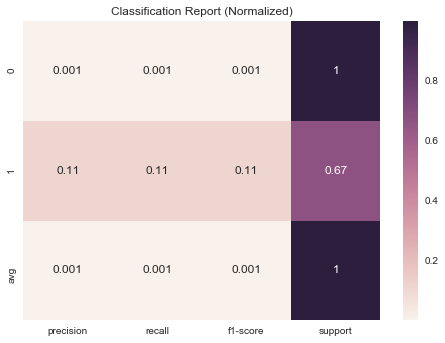

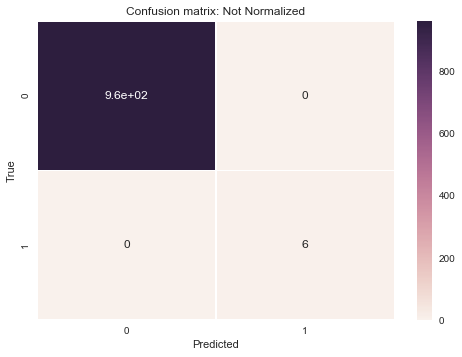

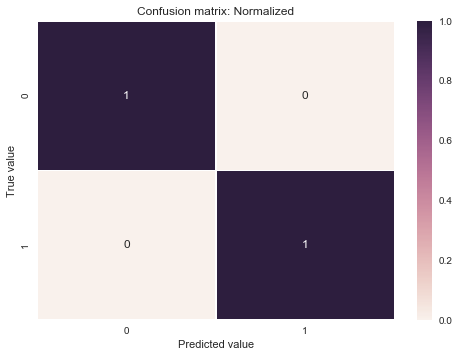

In [31]:
if __name__ == "__main__":
    main()

### done so far. kept the Rake eg below untouched.

In [61]:
data= pd.read_csv("datasets\dataframe.csv")
ds =pd.DataFrame()
ds['index']= data['index']
ds['pos'] = data['pos']
list_pos = []
for idx, row in ds.iterrows():
    if row['index']==1:
        list_pos.append(row['pos'])
new = pd.DataFrame(list_pos)

plt.grid(True)
new.hist()
plt.title("count of Parts of speech of words appearing in Index")
plt.ylabel('count')
plt.xlabel('POS')
plt.show()


ValueError: num must be 1 <= num <= 0, not 1

## Rake Example:
Below is a sample code that gets ranked phrases from rake. This is mainly used to generate keyphrases. We can fine tune this

In [ ]:
from rake_nltk import Rake
r = Rake()
r.extract_keywords_from_text(input_text)
print(r.get_ranked_phrases())